In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset

/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys

sys.path.append("..")

from adv_manhole.models import load_models, ModelType
from adv_manhole.attack.losses import AdvManholeLosses
from adv_manhole.texture_mapping.depth_utils import process_surface_coordinates

[2024-05-29 10:14:32] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/naufal/sg_logs/console.log


In [3]:
# Load the dataset
carla_dataset = load_dataset("naufalso/carla_hd", cache_dir="./data/")
print(carla_dataset)

In [4]:
filtered_columns_dataset = carla_dataset.select_columns(
    ["rgb", "raw_depth", "camera_config"]
)
print(filtered_columns_dataset)

In [5]:
# Load MonoDepth2 model
monodepth2_model = load_models(ModelType.MDE, "mono_640x192")

# Load DDRNet model
ddrnet_model = load_models(ModelType.SS, "ddrnet_23")

DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 532
    })
})


DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 532
    })
})


/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[2024-05-29 10:14:38] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the cityscapes dataset, published under the 

In [6]:
from torchvision import transforms

In [7]:
filtered_columns_dataset.items()

dict_items([('train', Dataset({
    features: ['rgb', 'raw_depth', 'camera_config'],
    num_rows: 1593
})), ('validation', Dataset({
    features: ['rgb', 'raw_depth', 'camera_config'],
    num_rows: 531
})), ('test', Dataset({
    features: ['rgb', 'raw_depth', 'camera_config'],
    num_rows: 532
}))])

In [8]:
data_iterable = {}
batch_size = 8

for data_type, dataset in filtered_columns_dataset.items():
    data_iterable[data_type] = dataset.to_iterable_dataset()
    data_iterable[data_type] = data_iterable[data_type].map(
        lambda example: {
            "local_surface_coors": transforms.ToTensor()(
                process_surface_coordinates(example["raw_depth"], example["camera_config"])
            ),
            "rgb": transforms.ToTensor()(example["rgb"]),
        },
        remove_columns=["raw_depth", "camera_config"],
    )
    data_iterable[data_type] = DataLoader(
        data_iterable[data_type],
        batch_size=batch_size,
    )

data_iterable

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f51801aad90>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7f518019ca90>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f51801840a0>}

In [9]:
def mapped_texture_mask(
    surface_xyz,
    tex_size=1.0,
    tex_shift=[0.0, 0.0, 0.0],
):

    x_offset = tex_shift[0]
    y_offset = tex_shift[1]

    # Mask the centerized local coordinates given the texture size
    texture_mask = torch.where(
        (surface_xyz[0, ...] > x_offset)
        & (surface_xyz[0, ...] < x_offset + tex_size)
        & (surface_xyz[1, ...] > y_offset)
        & (surface_xyz[1, ...] < y_offset + tex_size),
        1.0,
        0.0,
    )

    return texture_mask


def depth_texture_mapping(
    texture,
    surface_xyz,
    tex_size=1.0,
    tex_shift=[0.0, 0.0, 0.0],
    texture_res=256,
):
    # Convert to channel last
    surface_xyz = surface_xyz.permute(1, 2, 0)
    # normal_mask = normal_mask.permute(1, 2, 0)
    texture_flat = texture.permute(1, 2, 0).view(-1, 3)
    max_uv_idx = texture_res**2 - 1

    # Get the UV coordinates by modulating the surface coordinates with the texture size
    surface_xyz_mod = (surface_xyz - tex_shift) % tex_size
    surface_xyz_mod = surface_xyz_mod / tex_size

    # Get the UV indices by multiplying the UV coordinates with the texture resolution
    uv_idx = surface_xyz_mod * texture_res
    uv_idx = torch.round(uv_idx).to(torch.int64)
    uv_idx = torch.clamp(uv_idx, 0, texture_res - 1)

    # Get the UV indices for each axis
    uv_idx_z = uv_idx[..., [0, 1]]

    # Invert the z uv indices
    uv_idx_z[..., 0] = texture_res - uv_idx_z[..., 0]

    # Get the UV indices for each axis flattened
    uv_idx_z_flat = (uv_idx_z[..., 0] * texture_res + uv_idx_z[..., 1]).clamp_max(
        max_uv_idx
    )

    # Get the rendered images for each axis
    rendered_img_z = texture_flat[uv_idx_z_flat.flatten(), :].reshape(
        surface_xyz_mod.shape
    )

    # Reverse the channel last to channel first
    rendered_img_z = rendered_img_z.permute(2, 0, 1)

    return rendered_img_z

In [10]:
adversarial_texture = torch.rand((3, 256, 256))

In [11]:
adversarial_losses = AdvManholeLosses(
    mde_loss_weight=1.0,
    ss_ua_loss_weight=0.5,
    ss_ta_loss_weight=0.5,
    tv_loss_weight=0.25,
    background_loss_weight=0.25
)

In [12]:
import torch.optim as optim
from tqdm import tqdm

patch_texture_var = torch.nn.Parameter(adversarial_texture, requires_grad=True)

# Define the optimization pipeline
optimizer = optim.Adam([patch_texture_var], lr=0.01)

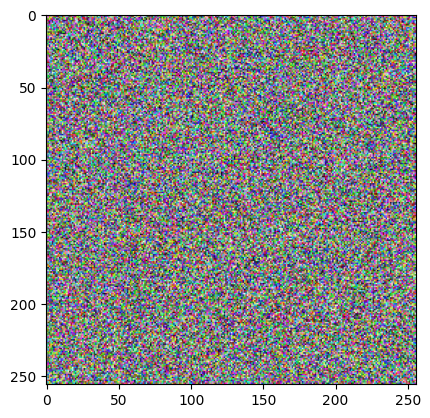

In [13]:
# Plot patch_texture_var
plt.imshow(patch_texture_var.permute(1, 2, 0).detach().cpu().numpy())
plt.show()


In [14]:
train_total_batch = len(filtered_columns_dataset["train"]) // batch_size + 1 if len(filtered_columns_dataset["train"]) % batch_size != 0 else 0
val_total_batch = len(filtered_columns_dataset["validation"]) // batch_size + 1 if len(filtered_columns_dataset["validation"]) % batch_size != 0 else 0
test_total_batch = len(filtered_columns_dataset["test"]) // batch_size + 1 if len(filtered_columns_dataset["test"]) % batch_size != 0 else 0

In [15]:
# Create color jitter transform for data augmentation
texture_augmentation = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ]
)

output_augmentation = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
    ]
)

In [16]:
original_index = 0 # Road
target_indices = list(range(1, 13))  # All classes except Road

In [17]:
from collections import defaultdict

In [18]:
epochs = 100
tex_min_size, tex_max_size = 0.5, 0.51  # 0.5, 0.75
tex_min_shift, tex_max_shift = -0.01, 0.01  # -0.4, 0.4

epoch_history = defaultdict(list)

for epoch in range(epochs):
    with tqdm(
        data_iterable['train'], total=train_total_batch, desc=f"Epoch {epoch + 1}/{epochs}"
    ) as train_pbar:
        train_history = defaultdict(list)
        for batch in train_pbar:
            optimizer.zero_grad()

            rgb = batch["rgb"]
            local_surface_coors = batch["local_surface_coors"]

            current_batch_size = rgb.shape[0]

            # Generate random texture size with shape [batch_size] ranging from [min_size, max_size]
            tex_size = (
                torch.rand(current_batch_size) * (tex_max_size - tex_min_size)
                + tex_min_size
            )

            # Generate random texture shift with shape [batch_size, 2] ranging from [min_shift, max_shift]
            tex_shift = (
                torch.rand(current_batch_size, 2) * (tex_max_shift - tex_min_shift)
                + tex_min_shift
            )

            # Add zeros to texture shift z axis
            tex_shift = torch.cat(
                [tex_shift, torch.zeros(current_batch_size, 1)], dim=1
            )

            # Shift the offset to center the texture
            tex_shift[:, 1] -= tex_size * 0.5

            # Generate texture masks. TODO: Vectorize this operation
            texture_masks = torch.stack(
                [
                    mapped_texture_mask(
                        local_surface_coors[i],
                        tex_size=tex_size[i],
                        tex_shift=tex_shift[i],
                    )
                    for i in range(current_batch_size)
                ]
            ).unsqueeze(1) # Add channel dimension

            # Repeat the texture to match the batch size
            batched_texture = patch_texture_var.unsqueeze(0).repeat(
                current_batch_size, 1, 1, 1
            )

            # Augment the texture with color jitter
            augmented_texture = torch.stack(
                [
                    texture_augmentation(batched_texture[i])
                    for i in range(current_batch_size)
                ]
            )

            # Generate the texture mapping
            texture_mapped_images = torch.stack(
                [
                    depth_texture_mapping(
                        augmented_texture[i],
                        local_surface_coors[i],
                        tex_size=tex_size[i],
                        tex_shift=tex_shift[i],
                    )
                    for i in range(current_batch_size)
                ]
            )

            # Apply the texture mask to the texture mapped images
            final_images = texture_mapped_images * texture_masks + rgb * (1.0 - texture_masks)

            # Apply the output augmentation
            augmented_final_images = torch.stack(
                [
                    output_augmentation(final_images[i])
                    for i in range(current_batch_size)
                ]
            )

            # Predict the depth and semantic segmentation
            predicted_depth = monodepth2_model(final_images) #augmented_final_images)
            predicted_semantic = ddrnet_model(augmented_final_images)

            # Calculate tv loss
            tv_loss = adversarial_losses.tv_loss(patch_texture_var)

            # Calculte background loss
            background_loss = adversarial_losses.background_loss(
                final_images, rgb, texture_masks.repeat(1, 3, 1, 1)
            )

            # Calculate mde loss
            mde_loss = adversarial_losses.adversarial_mde_loss(
                predicted_depth,
                torch.zeros_like(predicted_depth),
                texture_masks,
            )

            # # Calculate ss
            ss_ua_loss, ss_ta_loss = adversarial_losses.adversarial_ss_loss(
                predicted_semantic,
                original_index=original_index,
                target_indices=target_indices,
                masks=texture_masks,
            )

            # Calculate the total loss
            total_loss = (
                mde_loss + ss_ua_loss + ss_ta_loss + tv_loss + background_loss
            )

            # Backpropagate the loss
            total_loss.backward()
            optimizer.step()

            # Clip the texture to [0, 1]
            patch_texture_var.data.clamp_(0, 1)

            # Update the progress bar
            train_pbar.set_postfix(
                {
                    "MDE Loss": mde_loss.item(),
                    "SS UA Loss": ss_ua_loss.item(),
                    "SS TA Loss": ss_ta_loss.item(),
                    "TV Loss": tv_loss.item(),
                    "Background Loss": background_loss.item(),
                    "Total Loss": total_loss.item(),
                }
            )

            train_history["mde_loss"].append(mde_loss.item())
            # train_history["ss_ua_loss"].append(ss_ua_loss.item())
            # train_history["ss_ta_loss"].append(ss_ta_loss.item())
            train_history["tv_loss"].append(tv_loss.item())
            train_history["background_loss"].append(background_loss.item())
            train_history["total_loss"].append(total_loss.item())

        for key, value in train_history.items():
            epoch_history[key].append(np.mean(value))

Epoch 1/100:   0%|          | 0/199 [00:00<?, ?it/s]/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/100:  52%|█████▏    | 103/199 [03:31<03:15,  2.03s/it, MDE Loss=0.687, SS UA Loss=0.13, SS TA Loss=0.166, TV Loss=0.0784, Background Loss=0.0228, Total Loss=1.08]    

KeyboardInterrupt: 

Epoch 1/100:  52%|█████▏    | 103/199 [03:33<03:19,  2.07s/it, MDE Loss=0.687, SS UA Loss=0.13, SS TA Loss=0.166, TV Loss=0.0784, Background Loss=0.0228, Total Loss=1.08]


In [19]:
# Try to overfit to check if the optimization is working
with tqdm(range(1000), total=1000) as train_pbar:
    for i in train_pbar:
        optimizer.zero_grad()

        rgb = batch["rgb"]
        local_surface_coors = batch["local_surface_coors"]

        current_batch_size = rgb.shape[0]

        # Generate random texture size with shape [batch_size] ranging from [min_size, max_size]
        tex_size = (
            torch.rand(current_batch_size) * (tex_max_size - tex_min_size)
            + tex_min_size
        )

        # Generate random texture shift with shape [batch_size, 2] ranging from [min_shift, max_shift]
        tex_shift = (
            torch.rand(current_batch_size, 2) * (tex_max_shift - tex_min_shift)
            + tex_min_shift
        )

        # Add zeros to texture shift z axis
        tex_shift = torch.cat(
            [tex_shift, torch.zeros(current_batch_size, 1)], dim=1
        )

        # Shift the offset to center the texture
        tex_shift[:, 1] -= tex_size * 0.5

        # Generate texture masks. TODO: Vectorize this operation
        texture_masks = torch.stack(
            [
                mapped_texture_mask(
                    local_surface_coors[i],
                    tex_size=tex_size[i],
                    tex_shift=tex_shift[i],
                )
                for i in range(current_batch_size)
            ]
        ).unsqueeze(1) # Add channel dimension

        # Repeat the texture to match the batch size
        batched_texture = patch_texture_var.unsqueeze(0).repeat(
            current_batch_size, 1, 1, 1
        )

        # Augment the texture with color jitter
        augmented_texture = torch.stack(
            [
                texture_augmentation(batched_texture[i])
                for i in range(current_batch_size)
            ]
        )

        # Generate the texture mapping
        texture_mapped_images = torch.stack(
            [
                depth_texture_mapping(
                    augmented_texture[i],
                    local_surface_coors[i],
                    tex_size=tex_size[i],
                    tex_shift=tex_shift[i],
                )
                for i in range(current_batch_size)
            ]
        )

        # Apply the texture mask to the texture mapped images
        final_images = texture_mapped_images * texture_masks + rgb * (1.0 - texture_masks)

        # Apply the output augmentation
        augmented_final_images = torch.stack(
            [
                output_augmentation(final_images[i])
                for i in range(current_batch_size)
            ]
        )

        # Predict the depth and semantic segmentation
        predicted_depth = monodepth2_model(augmented_final_images)
        predicted_semantic = ddrnet_model(augmented_final_images)

        # Calculate tv loss
        tv_loss = adversarial_losses.tv_loss(patch_texture_var)

        # Calculte background loss
        background_loss = adversarial_losses.background_loss(
            final_images, rgb, texture_masks.repeat(1, 3, 1, 1)
        )

        # Calculate mde loss
        mde_loss = adversarial_losses.adversarial_mde_loss(
            predicted_depth,
            torch.zeros_like(predicted_depth),
            texture_masks,
        )

        # # Calculate ss
        ss_ua_loss, ss_ta_loss = adversarial_losses.adversarial_ss_loss(
            predicted_semantic,
            original_index=original_index,
            target_indices=target_indices,
            masks=texture_masks,
        )

        # Calculate the total loss
        total_loss = (
            mde_loss + ss_ua_loss + ss_ta_loss + tv_loss + background_loss
        )

        # Backpropagate the loss
        total_loss.backward()
        optimizer.step()

        # Clip the texture to [0, 1]
        patch_texture_var.data.clamp_(0, 1)

        # Update the progress bar
        train_pbar.set_postfix(
            {
                "MDE Loss": mde_loss.item(),
                "SS UA Loss": ss_ua_loss.item(),
                "SS TA Loss": ss_ta_loss.item(),
                "TV Loss": tv_loss.item(),
                "Background Loss": background_loss.item(),
                "Total Loss": total_loss.item(),
            }
        )

  2%|▏         | 16/1000 [00:23<24:23,  1.49s/it, MDE Loss=0.634, SS UA Loss=0.0448, SS TA Loss=0.0706, TV Loss=0.0773, Background Loss=0.0285, Total Loss=0.855]

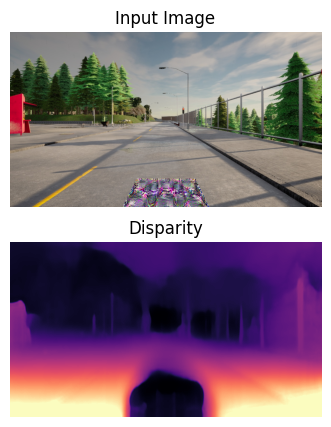

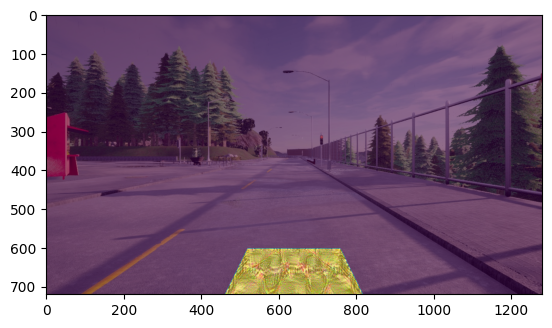

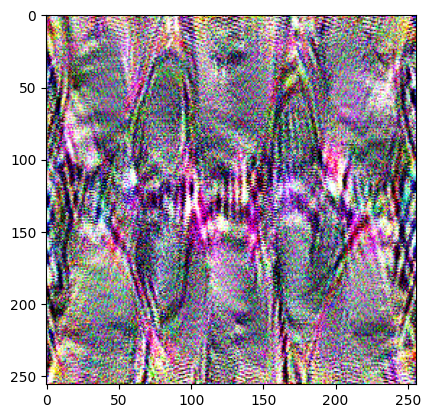

In [21]:
# Plot mde
fig = monodepth2_model.plot(
    image=final_images[0].permute(1, 2, 0).detach().cpu().numpy(),
    prediction=predicted_depth[0].detach(),
)
plt.show()

# Plot ss
fig = ddrnet_model.plot(
    image=final_images[0].permute(1, 2, 0).detach().cpu().numpy(),
    prediction=predicted_semantic[0].detach(),
)
plt.show()

# Plot mask
plt.imshow(final_images[0].permute(1, 2, 0).detach().cpu().numpy())
plt.imshow(texture_masks[0].detach().squeeze(0).cpu().numpy(), alpha=0.5)
plt.show()

plt.imshow(patch_texture_var.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

In [31]:
valid_depth = predicted_depth[texture_masks  >0.5]
valid_depth.shape

torch.Size([307559])

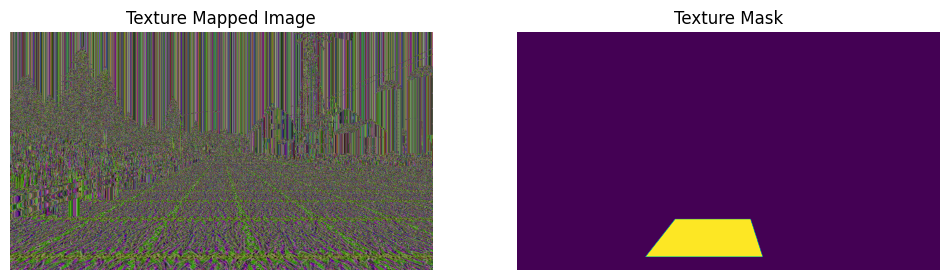

In [22]:
# Plot texture_mapped_images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(texture_mapped_images.detach().cpu()[0].permute(1, 2, 0).numpy())
plt.title("Texture Mapped Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(texture_masks[0].detach().squeeze().cpu().numpy())
plt.title("Texture Mask")
plt.axis("off")
plt.show()

In [27]:
texture_mapped_images.shape

torch.Size([8, 3, 720, 1280])